# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/asheemchhetri/AI_with_python_Udacity/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Important Google Colab setup
# PIL setup
!pip uninstall -y Pillow
!pip install -q Pillow==5.4.0
# %reload_ext autoreload
# %autoreload
# PyTorch setup
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!cat cat_to_name.json

# Fetching the image data-sets
# !wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
# !unzip -qq flower_data.zip

# model_save_name = 'checkpoint.pt'
# path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}" 
# torch.save(model.state_dict(), path)

Uninstalling Pillow-5.4.0:
  Successfully uninstalled Pillow-5.4.0
Mounted at /content/gdrive
{"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet cre

In [0]:
# I uploaded the file to my virtual space, once uploaded I am unzipping it here
# Note: We have to load the file each time the runtime is reset
path = F"/content/gdrive/My\ Drive/Udacity/PyTorch_scholarship/final_project/flowers"
!unzip -qq {path}

In [3]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import PIL
from PIL import Image
print(PIL.__version__)
import time
import json

# Refer to Lecture 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

5.4.0
CUDA is available!  Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [0]:
data_dir = '/content/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# ----------------------------------------------------------------------------------------------
# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
# ----------------------------------------------------------------------------------------------
# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle=True) # batch_size changed from 64 to 68
validationloader = torch.utils.data.DataLoader(validation_data, batch_size = 32, shuffle=False)# batch_size changed from 32 to 32
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle=False)# batch_size changed from 32 to 32

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
!ls
!pwd

cat_to_name.json  flowers  gdrive  sample_data
/content


In [0]:
with open('/content/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [7]:
# TODO: Build and train your network
# Loading a pretrained netwrok, decided to use densenet121 based on Lecture 11.

arch = 'densenet161'
model = models.densenet161(pretrained=True)
# arch = 'densenet121'
# model = models.densenet121(pretrained=True)
# model = models.vgg16(pretrained=True)
# print(model)
for name, child in model.named_children():
    print(name)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:02<00:00, 47795125.59it/s]


features
classifier


In [0]:

# Freezing the parameters

for param in model.parameters():
    param.require_grad = False

input_size = 2208
output_size = 102 # given
learn_rate = 0.001 # back propogation rate changed from 0.001 to 0.01

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, 600)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(600, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr = learn_rate, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
# Training the model, for more reference reffer to Lecture 10
# device_source: Tells which device to use, either cuda or cpu
# model: Our pretrained model
# epochs: How many time to run
# valid_flag: Just to tell us, if user using validationloader or trainloader
# True: validationloader
# False: testloader
def train_network(device_source, model, epochs, training_data, test_data, valid_flag):
    trainloader = training_data
    '''
    data_to_test can be either testloader or validation loader
    Based on review, this is change 1 to accept validationloader
    '''
    data_to_test = test_data

    loss_set = []
    accuracy_set =[]
    start = time.time()
    # print_every affects the print statement(i.e. 50 => 2 line per epoch, 10 => 10 line per epoch, etc. (100/print_every))
    print_every = 50
    steps = 0

    # GPU mode enabled
    model.to(device_source)

    for e in range(epochs):
        running_loss = 0
        model.train()
        scheduler.step() # Using StepLR scheduler
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                # Make sure network is in eval mode for inference
                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    test_loss, accuracy = validation(device_source, model, data_to_test, criterion)
                loss_set.append(test_loss/len(data_to_test))
                accuracy_set.append(accuracy/len(data_to_test))
                
                if valid_flag:
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(test_loss/len(data_to_test)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(data_to_test)))    

                else:
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Test Loss: {:.3f}.. ".format(test_loss/len(data_to_test)),
                          "Test Accuracy: {:.3f}".format(accuracy/len(data_to_test)))
                    
                running_loss = 0
                model.train()
    end = time.time()
    diff = end - start
    print("\nTotal time taken: {:.0f} minutes {:.0f} seconds".format(diff//60, diff%60))
    return loss_set, accuracy_set

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [0]:
# TODO: Do validation on the test set
# Refer to Lecture 7
def validation(device_source, model, data_to_test, criterion):
    test_loss = 0
    accuracy = 0
    model.to(device_source)
    for images, labels in data_to_test:
        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy

In [12]:
print(device)
epochs = 20 

loss_record, accuracy_record = train_network(device, model, epochs, trainloader, validationloader, True)
# print(loss_record)
# print(accuracy_record)

cuda:0
Epoch: 1/20..  Training Loss: 4.224..  Validation Loss: 3.529..  Validation Accuracy: 0.270
Epoch: 1/20..  Training Loss: 2.979..  Validation Loss: 2.170..  Validation Accuracy: 0.546
Epoch: 1/20..  Training Loss: 2.010..  Validation Loss: 1.337..  Validation Accuracy: 0.699
Epoch: 1/20..  Training Loss: 1.508..  Validation Loss: 0.954..  Validation Accuracy: 0.793
Epoch: 2/20..  Training Loss: 0.987..  Validation Loss: 0.708..  Validation Accuracy: 0.824
Epoch: 2/20..  Training Loss: 0.913..  Validation Loss: 0.610..  Validation Accuracy: 0.855
Epoch: 2/20..  Training Loss: 0.852..  Validation Loss: 0.483..  Validation Accuracy: 0.896
Epoch: 2/20..  Training Loss: 0.747..  Validation Loss: 0.488..  Validation Accuracy: 0.895
Epoch: 3/20..  Training Loss: 0.497..  Validation Loss: 0.435..  Validation Accuracy: 0.896
Epoch: 3/20..  Training Loss: 0.643..  Validation Loss: 0.404..  Validation Accuracy: 0.907
Epoch: 3/20..  Training Loss: 0.563..  Validation Loss: 0.367..  Validati

In [13]:
# Determining the accuracy of our model, since the value are already feeded into a list, we will just fetch the last record.
print("\n----------Validation Result-------------\n")
print("Validation Loss: {:.4f}\nAccuracy: {:.4f}\nAccuracy(in %): {:.2f}%".format(loss_record[-1], accuracy_record[-1], accuracy_record[-1] * 100))
print("\n--------------Test Result---------------\n")
model.eval()
with torch.no_grad():
    loss_record_test, accuracy_record_test = validation(device, model, testloader, criterion)

print("Test Accuracy: {:.2f} %".format((accuracy_record_test/len(testloader)) * 100))



----------Validation Result-------------

Validation Loss: 0.1749
Accuracy: 0.9618
Accuracy(in %): 96.18%

--------------Test Result---------------

Test Accuracy: 96.59 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
'''
Change 2 based on Review:
Don't save entire model, as it is inefficient and consumes memory.

>>>> Old code ->
before_saving = model.state_dict().keys()
print(before_saving)
checkpoint = {'input_size': 1024,
              'output_size': 102,
              'epochs': epochs,
              'state_dict': model.state_dict(),
              'optimizer_dict': optimizer.state_dict(),
              'criterion': criterion,
              'learn_rate': learn_rate,
              'class_to_idx': train_data.class_to_idx,
              'model': model
             }

torch.save(checkpoint, 'checkpoint.pth')
Important note: Obtain which architecture you are using, so it can be used to rebuild the model and proceed as usual.
For this notebook I am using densenet121
'''
before_saving = model.state_dict().keys()
print(before_saving)
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'arch': arch,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'learn_rate': learn_rate,
              'class_to_idx': train_data.class_to_idx,
             }

model_save_name = 'checkpoint.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
torch.save(checkpoint, path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    '''
    One issue that someone might face, how to open checkpoint made on gpu on a cpu device
    For more info and code reference for this issue, please refer to this pytorch community site
    https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349
    '''
    if device == "cuda":
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)

    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    # ^^^ Based on review. Also freeze the params ^^^
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.optimizer = checkpoint['optimizer']
    model.epochs = checkpoint['epochs']
    model.learn_rate = checkpoint['learn_rate']
    
    return model
  
model_save_name = 'checkpoint.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
model = load_checkpoint(path)
after_loading = model.state_dict().keys()
# print(after_loading)
# model

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


**Pass 2**

---


**Loading the old checkpoint here**

We will unfreeze the model here and retrain

1. Using the old training where I got 95.7% with your help yesterday.
2. Loaded old checkpoint in load_checkpoint_optimized(), and unfroze all params in it.
3. Return new model
4. Change learn-rate to 0.00001
5. Optimzer uses model.parameters() now
6. Retraining with 15 epochs
7. Saving new model to diff checkpoint file
8. Load it, and test inference...



In [0]:
def load_checkpoint_optimized(filepath):
    if device == "cuda":
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)

    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    for param in model.parameters():
        param.require_grad = True
        
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.optimizer = checkpoint['optimizer']
    model.epochs = checkpoint['epochs']
    model.learn_rate = checkpoint['learn_rate']
    
    return model
  
# model_save_name = 'checkpoint.pt'
# path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
# model = load_checkpoint_optimized(path)

In [13]:
# Retraining
learn_rate = 0.000001 # Starting with lower learn rate
optimizer = optim.Adam(model.parameters(), lr = learn_rate, amsgrad=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=10)
criterion = nn.NLLLoss()
print(device)
epochs = 15 # retraining epoch
loss_record, accuracy_record = train_network(device, model, epochs, trainloader, validationloader, True)


cuda:0
Epoch: 1/15..  Training Loss: 0.269..  Validation Loss: 0.170..  Validation Accuracy: 0.961
Epoch: 1/15..  Training Loss: 0.237..  Validation Loss: 0.171..  Validation Accuracy: 0.963
Epoch: 1/15..  Training Loss: 0.241..  Validation Loss: 0.166..  Validation Accuracy: 0.962
Epoch: 1/15..  Training Loss: 0.250..  Validation Loss: 0.168..  Validation Accuracy: 0.964
Epoch: 2/15..  Training Loss: 0.205..  Validation Loss: 0.164..  Validation Accuracy: 0.962
Epoch: 2/15..  Training Loss: 0.272..  Validation Loss: 0.162..  Validation Accuracy: 0.963
Epoch: 2/15..  Training Loss: 0.208..  Validation Loss: 0.163..  Validation Accuracy: 0.964
Epoch: 2/15..  Training Loss: 0.252..  Validation Loss: 0.165..  Validation Accuracy: 0.963
Epoch: 3/15..  Training Loss: 0.162..  Validation Loss: 0.157..  Validation Accuracy: 0.964
Epoch: 3/15..  Training Loss: 0.232..  Validation Loss: 0.155..  Validation Accuracy: 0.964
Epoch: 3/15..  Training Loss: 0.208..  Validation Loss: 0.156..  Validati

In [14]:
# Determining the accuracy of our model, since the value are already feeded into a list, we will just fetch the last record.
print("\n----------Validation Result-------------\n")
print("Validation Loss: {:.4f}\nAccuracy: {:.4f}\nAccuracy(in %): {:.2f}%".format(loss_record[-1], accuracy_record[-1], accuracy_record[-1] * 100))
print("\n--------------Test Result---------------\n")
model.eval()
with torch.no_grad():
    loss_record_test, accuracy_record_test = validation(device, model, testloader, criterion)

print("Test Accuracy: {:.2f} %".format((accuracy_record_test/len(testloader)) * 100))


----------Validation Result-------------

Validation Loss: 0.0789
Accuracy: 0.9844
Accuracy(in %): 98.44%

--------------Test Result---------------

Test Accuracy: 98.48 %


In [15]:
# Saving new checkpoint
before_saving = model.state_dict().keys()
print(before_saving)
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'arch': arch,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'learn_rate': learn_rate,
              'class_to_idx': train_data.class_to_idx,
             }

model_save_name = 'checkpoint_optimized_new_jan_9.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
torch.save(checkpoint, path)

odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2



---


**Pass 3**

---


Validation Accuracy as of now: 98.48%

---

Retraining it once more with small epoch as it seems learn-rate = 0.001 is producing good result.
Also freezing the model.

In [0]:
def load_checkpoint(filepath):
    '''
    One issue that someone might face, how to open checkpoint made on gpu on a cpu device
    For more info and code reference for this issue, please refer to this pytorch community site
    https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349
    '''
    if device == "cuda":
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)

    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    # ^^^ Based on review. Also freeze the params ^^^
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.optimizer = checkpoint['optimizer']
    model.epochs = checkpoint['epochs']
    model.learn_rate = checkpoint['learn_rate']
    
    return model

In [54]:
# Loading new Checkpoint for inference
model_save_name = 'checkpoint_optimized_new_jan_9.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
model = load_checkpoint_optimized(path)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [55]:
# Retraining
learn_rate = 0.00005 # 0.00001 => 0.0001
optimizer = optim.Adam(model.parameters(), lr = learn_rate, amsgrad=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1)
criterion = nn.NLLLoss()
print(device)
epochs = 2 # retraining epoch
loss_record, accuracy_record = train_network(device, model, epochs, trainloader, validationloader, True)

cuda:0
Epoch: 1/5..  Training Loss: 0.097..  Validation Loss: 0.092..  Validation Accuracy: 0.977
Epoch: 1/5..  Training Loss: 0.080..  Validation Loss: 0.072..  Validation Accuracy: 0.984
Epoch: 1/5..  Training Loss: 0.120..  Validation Loss: 0.084..  Validation Accuracy: 0.981
Epoch: 1/5..  Training Loss: 0.119..  Validation Loss: 0.058..  Validation Accuracy: 0.987
Epoch: 2/5..  Training Loss: 0.096..  Validation Loss: 0.056..  Validation Accuracy: 0.988
Epoch: 2/5..  Training Loss: 0.104..  Validation Loss: 0.056..  Validation Accuracy: 0.990
Epoch: 2/5..  Training Loss: 0.088..  Validation Loss: 0.065..  Validation Accuracy: 0.990
Epoch: 2/5..  Training Loss: 0.097..  Validation Loss: 0.064..  Validation Accuracy: 0.989
Epoch: 3/5..  Training Loss: 0.075..  Validation Loss: 0.065..  Validation Accuracy: 0.992
Epoch: 3/5..  Training Loss: 0.092..  Validation Loss: 0.065..  Validation Accuracy: 0.990
Epoch: 3/5..  Training Loss: 0.088..  Validation Loss: 0.076..  Validation Accuracy

In [56]:
# Determining the accuracy of our model, since the value are already feeded into a list, we will just fetch the last record.
print("\n----------Validation Result-------------\n")
print("Validation Loss: {:.4f}\nAccuracy: {:.4f}\nAccuracy(in %): {:.2f}%".format(loss_record[-1], accuracy_record[-1], accuracy_record[-1] * 100))
print("\n--------------Test Result---------------\n")
model.eval()
with torch.no_grad():
    loss_record_test, accuracy_record_test = validation(device, model, testloader, criterion)

print("Test Accuracy: {:.2f} %".format((accuracy_record_test/len(testloader)) * 100))


----------Validation Result-------------

Validation Loss: 0.0704
Accuracy: 0.9868
Accuracy(in %): 98.68%

--------------Test Result---------------

Test Accuracy: 98.96 %


In [57]:
# Saving new checkpoint
before_saving = model.state_dict().keys()
print(before_saving)
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'arch': arch,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'learn_rate': learn_rate,
              'class_to_idx': train_data.class_to_idx,
             }

model_save_name = 'checkpoint_optimized_jan_9_98_96.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
torch.save(checkpoint, path)




odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2



---


**Pass 4**


---
learn rate: 0.00001

epoch: 1


In [61]:
# Loading new Checkpoint for inference
model_save_name = 'checkpoint_optimized_jan_9_98_96.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
model = load_checkpoint_optimized(path)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [62]:
# Retraining
learn_rate = 0.00001 
optimizer = optim.Adam(model.parameters(), lr = learn_rate, amsgrad=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1)
criterion = nn.NLLLoss()
print(device)
epochs = 1 # retraining epoch
loss_record, accuracy_record = train_network(device, model, epochs, trainloader, validationloader, True)

cuda:0
Epoch: 1/1..  Training Loss: 0.071..  Validation Loss: 0.072..  Validation Accuracy: 0.989
Epoch: 1/1..  Training Loss: 0.076..  Validation Loss: 0.067..  Validation Accuracy: 0.993
Epoch: 1/1..  Training Loss: 0.086..  Validation Loss: 0.063..  Validation Accuracy: 0.993
Epoch: 1/1..  Training Loss: 0.063..  Validation Loss: 0.064..  Validation Accuracy: 0.992

Total time taken: 9 minutes 57 seconds


In [63]:
# Determining the accuracy of our model, since the value are already feeded into a list, we will just fetch the last record.
print("\n----------Validation Result-------------\n")
print("Validation Loss: {:.4f}\nAccuracy: {:.4f}\nAccuracy(in %): {:.2f}%".format(loss_record[-1], accuracy_record[-1], accuracy_record[-1] * 100))
print("\n--------------Test Result---------------\n")
model.eval()
with torch.no_grad():
    loss_record_test, accuracy_record_test = validation(device, model, testloader, criterion)

print("Test Accuracy: {:.2f} %".format((accuracy_record_test/len(testloader)) * 100))


----------Validation Result-------------

Validation Loss: 0.0636
Accuracy: 0.9916
Accuracy(in %): 99.16%

--------------Test Result---------------

Test Accuracy: 99.08 %


In [64]:
# Saving new checkpoint
before_saving = model.state_dict().keys()
print(before_saving)
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'arch': arch,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'learn_rate': learn_rate,
              'class_to_idx': train_data.class_to_idx,
             }

model_save_name = 'checkpoint_optimized_jan_9_99_16.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
torch.save(checkpoint, path)

odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2



---

**Pass 5**

---

learn_rate: 0.0000001

epoch: 2

In [81]:
# Loading new Checkpoint for inference
model_save_name = 'checkpoint_optimized_jan_9_99_16.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
model = load_checkpoint_optimized(path)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [82]:
# Retraining
learn_rate = 0.0000001
optimizer = optim.Adam(model.parameters(), lr = learn_rate, amsgrad=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1)
criterion = nn.NLLLoss()
print(device)
epochs = 2 # retraining epoch
loss_record, accuracy_record = train_network(device, model, epochs, trainloader, validationloader, True)

cuda:0
Epoch: 1/2..  Training Loss: 0.060..  Validation Loss: 0.064..  Validation Accuracy: 0.992
Epoch: 1/2..  Training Loss: 0.056..  Validation Loss: 0.064..  Validation Accuracy: 0.992
Epoch: 1/2..  Training Loss: 0.050..  Validation Loss: 0.065..  Validation Accuracy: 0.989
Epoch: 1/2..  Training Loss: 0.064..  Validation Loss: 0.063..  Validation Accuracy: 0.989
Epoch: 2/2..  Training Loss: 0.065..  Validation Loss: 0.064..  Validation Accuracy: 0.992
Epoch: 2/2..  Training Loss: 0.054..  Validation Loss: 0.065..  Validation Accuracy: 0.990
Epoch: 2/2..  Training Loss: 0.077..  Validation Loss: 0.062..  Validation Accuracy: 0.989
Epoch: 2/2..  Training Loss: 0.075..  Validation Loss: 0.062..  Validation Accuracy: 0.993

Total time taken: 19 minutes 50 seconds


In [83]:
# Determining the accuracy of our model, since the value are already feeded into a list, we will just fetch the last record.
print("\n----------Validation Result-------------\n")
print("Validation Loss: {:.4f}\nAccuracy: {:.4f}\nAccuracy(in %): {:.2f}%".format(loss_record[-1], accuracy_record[-1], accuracy_record[-1] * 100))
print("\n--------------Test Result---------------\n")
model.eval()
with torch.no_grad():
    loss_record_test, accuracy_record_test = validation(device, model, testloader, criterion)

print("Test Accuracy: {:.2f} %".format((accuracy_record_test/len(testloader)) * 100))


----------Validation Result-------------

Validation Loss: 0.0618
Accuracy: 0.9928
Accuracy(in %): 99.28%

--------------Test Result---------------

Test Accuracy: 99.20 %


In [84]:
# Saving new checkpoint
before_saving = model.state_dict().keys()
print(before_saving)
checkpoint = {'input_size': 2208,
              'output_size': 102,
              'arch': arch,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'learn_rate': learn_rate,
              'class_to_idx': train_data.class_to_idx,
             }

model_save_name = 'checkpoint_optimized_jan_9_99_28.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
torch.save(checkpoint, path)

odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2



---

Reloading the model, so I can save it again with state_dict, classifier and class_to_idx for kaggle competition.

---

In [17]:
# Loading new Checkpoint for inference
model_save_name = 'checkpoint_optimized_jan_9_99_28.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
model = load_checkpoint_optimized(path)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [18]:
# Saving new checkpoint for <<<Kaggle>>>
before_saving = model.state_dict().keys()
print(before_saving)
checkpoint = {
#               'arch': arch,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'class_to_idx': train_data.class_to_idx,
             }

model_save_name = 'checkpoint_optimized_jan_9_99_28_kaggle.pt'
path = F"/content/gdrive/My Drive/Udacity/PyTorch_scholarship/final_project/{model_save_name}"
torch.save(checkpoint, path)

odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
'''
Change 3: Suggestion is to use native python image processing rather transforms, to understand PIL library.
def process_image(image):
    # Scales, crops, and normalizes a PIL image for a PyTorch model,
    # returns an Numpy array
    
    img = Image.open(image)
#     print(img)
#     print(type(img))
#     print('\n-------------------------------------------------\n')
    img_mods = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])])
    # Apply transformations to the image
    img = img_mods(img).numpy()
#     print(img)
#     print('\n-------------------------------------------------\n')
#     print(type(img))
#     print(img.shape)
#     print('\n-------------------------------------------------\n')
    
#     np_image = img / 255
#     img_new = np_image.transpose((2, 0, 1))

    return img
    # TODO: Process a PIL image for use in a PyTorch model
'''
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    width, height = img.size
    size = 256
    crop = 224
    
    # Resizing the image
    # Good Clarification: https://stackoverflow.com/questions/4321290/how-do-i-make-pil-take-into-account-the-shortest-side-when-creating-a-thumbnail
    if width <= height: 
        img = img.resize((size, int((width / height) * size)))
    else:
        img = img.resize((int((width / height) * size), size))
    
    # Cropping the image
    # The crop rectangle, as a (left, upper, right, lower)-tuple (PIL-documentation)
    # Source: https://stackoverflow.com/questions/9983263/crop-the-image-using-pil-in-python
    img = img.crop((((img.size[0] - crop)/2), ((img.size[1] - crop)/2), ((img.size[0] + crop)/2), ((img.size[1] + crop)/2)))    
    
    # Normalization
    new_image = np.array(img) / 255
    new_image = (new_image - mean)/std
    new_image = new_image.transpose((2, 0, 1))
    
    return new_image
    # TODO: Process a PIL image for use in a PyTorch model


(500, 591)


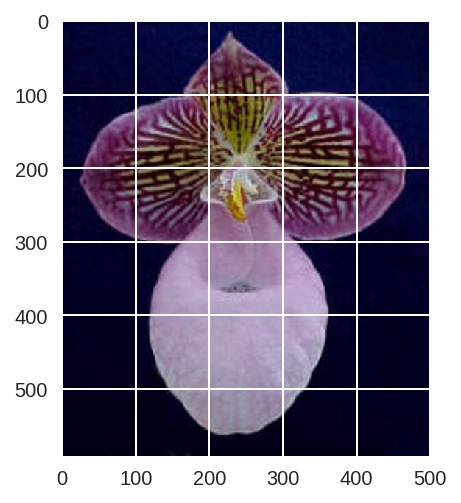

In [24]:
# with Image.open('flowers/test/1/image_06743.jpg') as image:
#     print(image.size)
#     plt.imshow(image)
with Image.open('flowers/test/2/image_05133.jpg') as image:
    print(image.size)
    plt.imshow(image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


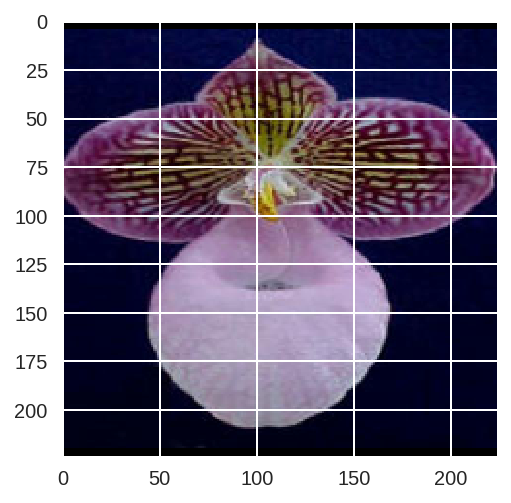

In [26]:
imshow(process_image("flowers/test/2/image_05133.jpg"))
# imshow(process_image("flowers/test/1/image_06743.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
# Make sure to invert the dictionary so you get a mapping from index to class as well.
# print(train_data.class_to_idx.items())
inverted_dict = {}
for k,v in train_data.class_to_idx.items():
    inverted_dict[v] = k
# print(inverted_dict)
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    if device == 'cuda:0': model.to('cuda')
    else: model.to('cpu')
    
    img_data = torch.from_numpy(process_image(image_path)).unsqueeze_(0).float()
    model.eval()
    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(img_data)

    ps = torch.exp(output)
    prob, classes = ps.topk(topk)
    prob = prob.numpy()[0]
    # print(prob)
    # print('Classes tensor was converted to numpy array, to help indexing the inverted_dictionary.')
    # print(classes)
    # Initial value is tensor, we must convert classes tensor to numpy, so we can index the dictionary using it.
    classes = classes.numpy()[0]
    p_val = [i for i in prob]
    c_val = [inverted_dict[i] for i in classes]
    # print(c_val)
    return p_val, c_val
    # TODO: Implement the code to predict the class from an image file



-----------------Prediction Testing---------------

Probability:	[0.99862385, 0.0010018856, 0.00028499085, 5.5800705e-05, 9.755869e-06]
Classes:	['1', '97', '19', '95', '40']
Names:		['pink primrose', 'mallow', 'balloon flower', 'bougainvillea', 'lenten rose']

			   Tabular View

 --------------------------------------------------------------------------------- 
|Flower Name                        |Probability (4dp *) |Probability (%)|Class   |
|---------------------------------------------------------------------------------|
|Pink Primrose                      |0.9986              |99.86          |1       |
|Mallow                             |0.0010              |0.10           |97      |
|Balloon Flower                     |0.0003              |0.03           |19      |
|Bougainvillea                      |0.0001              |0.01           |95      |
|Lenten Rose                        |0.0000              |0.00           |40      |
 --------------------------------------------

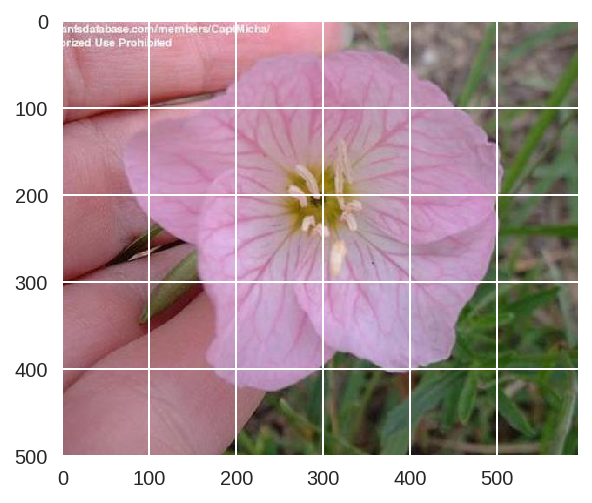

In [86]:
print('\n-----------------Prediction Testing---------------\n')    
#Testing our prediction
# path = 'flowers/test/10/image_07090.jpg'
# path = 'flowers/test/2/image_05133.jpg'
path = 'flowers/test/1/image_06754.jpg'
# path = 'flowers/valid/101/image_07962.jpg'
with Image.open(path) as image:
    #     print(image.size)
    plt.imshow(image)
prob,classes = predict(path, model, 5)
flower_name = [cat_to_name[x] for x in classes]

print("Probability:\t{}".format(prob))
print("Classes:\t{}".format(classes))
print("Names:\t\t{}".format(flower_name))
print("\n\t\t\t   Tabular View\n")
result = zip(prob, classes, flower_name)
print("{}{}{}".format(' ',"-"*(35+20+14+12),' '))
print("|%-35s|%-20s|%-14s|%-8s|"% ("Flower Name","Probability (4dp *)","Probability (%)","Class"))
print("{}{}{}".format('|',"-"*(35+20+14+12),'|'))
for p,c,f in result:
    print("|%-35s|%-20.4f|%-15.2f|%-8s|"% (f.title(),p,(p*100),c))
print("{}{}{}".format(' ',"-"*(35+20+14+12),' '))
print("\n*4dp: 4 decimal point")

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/asheemchhetri/AI_with_python_Udacity/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes
# Similar to what we did above, but now displaying it nicely using matplotlib
def sanity_check(path):
    # Lets view the image we want to check
    
    
    probability_val, class_val = predict(path, model)
    names = [cat_to_name[x] for x in class_val]

    with Image.open(path) as image:
        plt.imshow(image)
    plt.axis('off')
    #We need to capture name based on actual path
    label_num = path.split('/')[2]
    plt.title(cat_to_name[label_num])
    
    fig, chart = plt.subplots(figsize=(6, 5), nrows=1)
    y_pos = np.arange(len(classes))
    chart.barh(y_pos, probability_val)
    chart.set_yticks(y_pos)
    chart.set_yticklabels(names)
    chart.invert_yaxis()
    chart.set_ylabel('Flower Name')
    chart.set_xlabel('Probability')
    

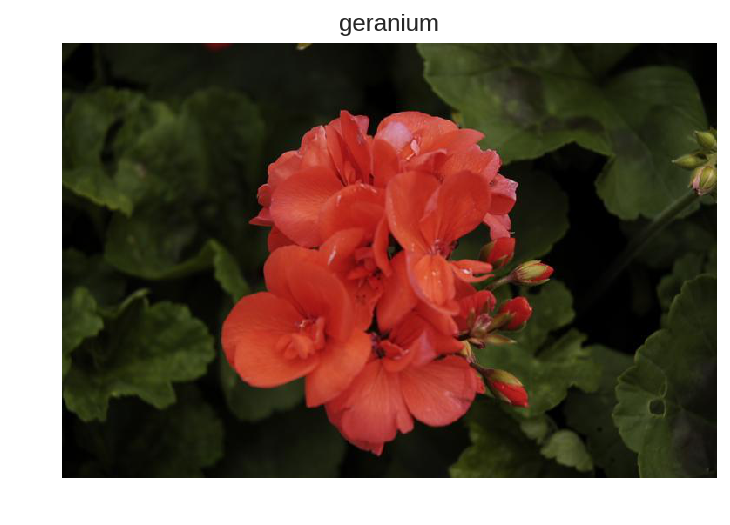

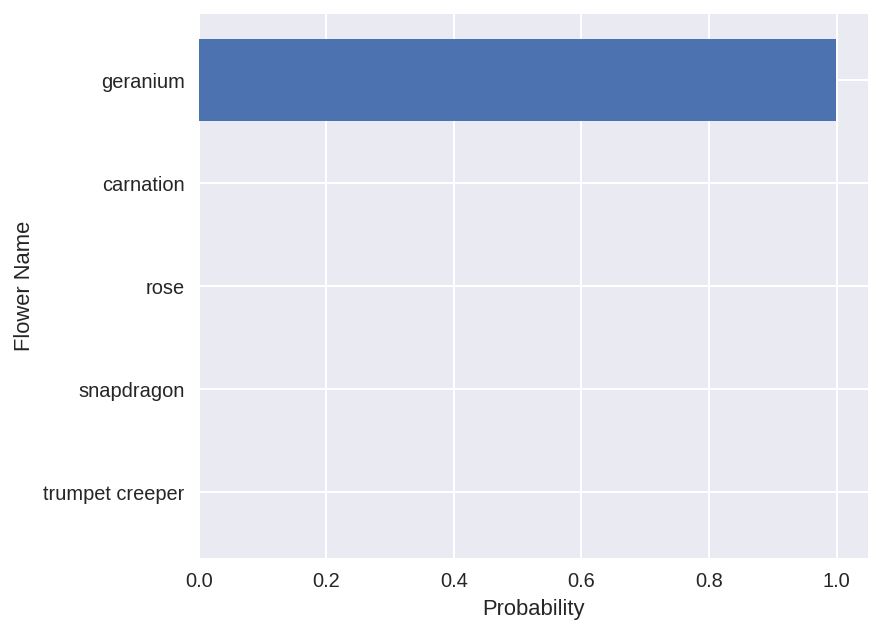

In [34]:
path = 'flowers/test/58/image_02719.jpg'
sanity_check(path)

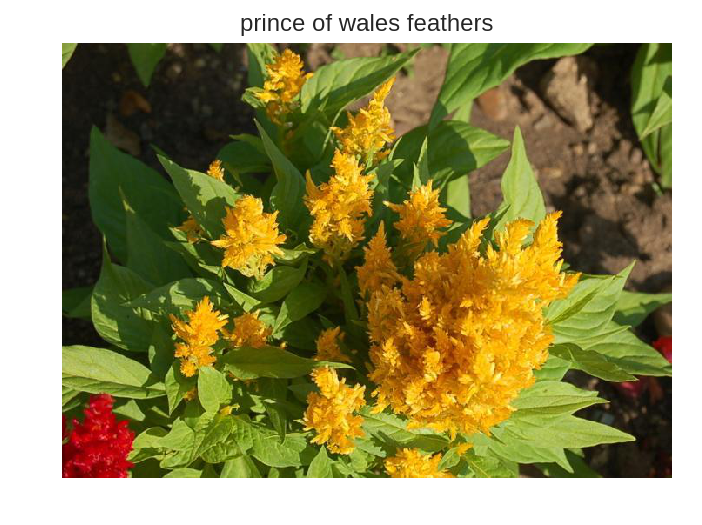

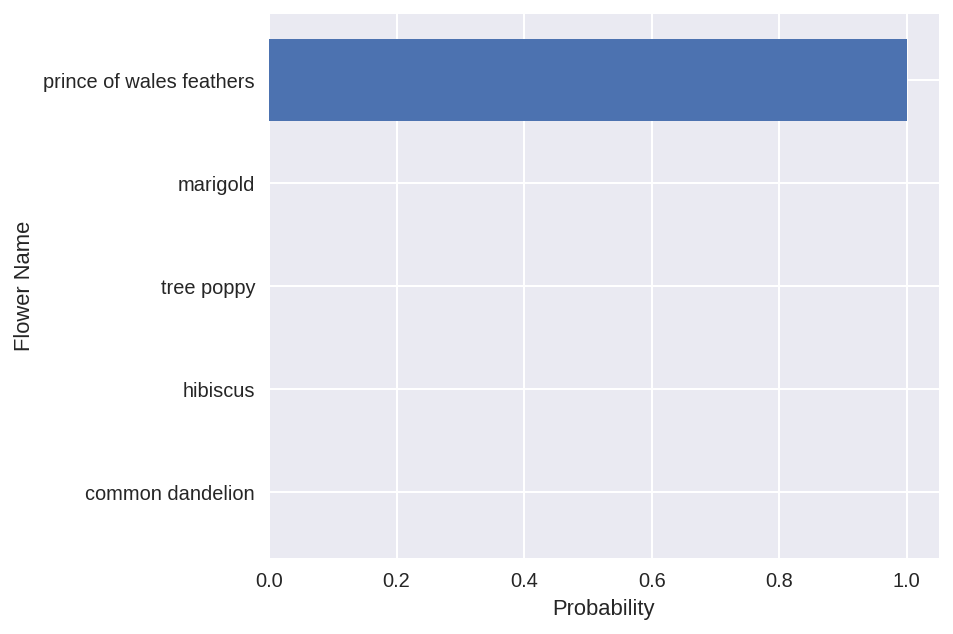

In [35]:
path = 'flowers/valid/27/image_06868.jpg'
sanity_check(path)

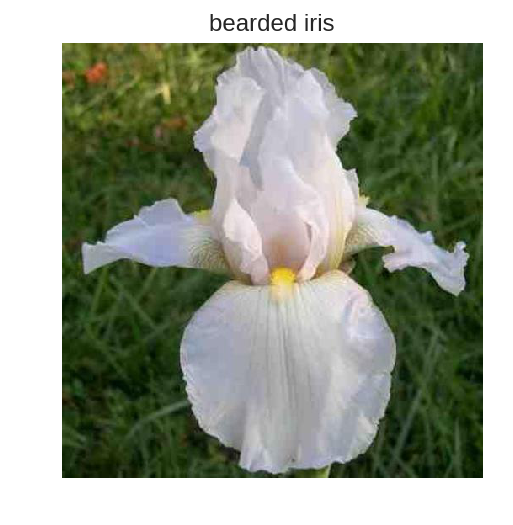

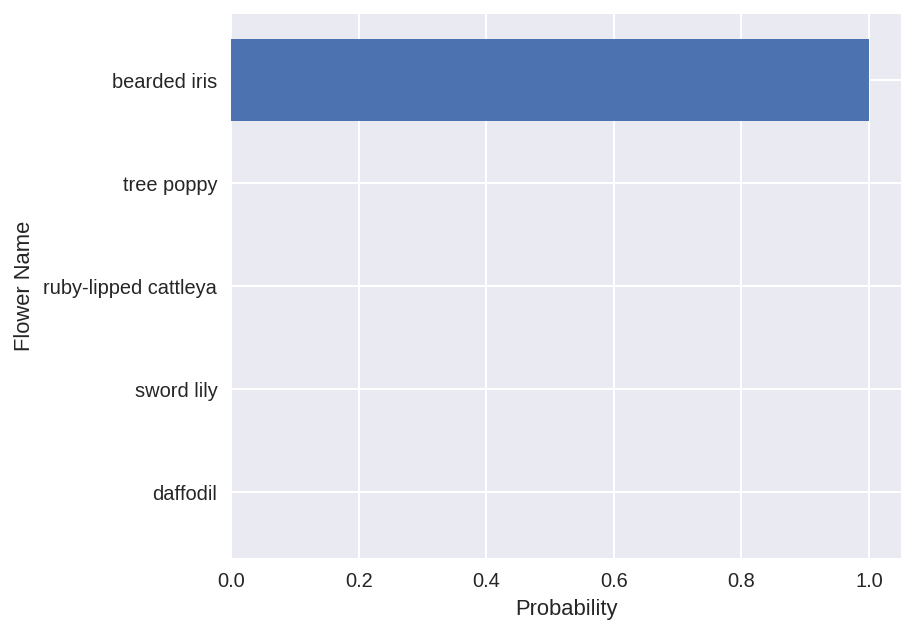

In [36]:
path = 'flowers/valid/68/image_05915.jpg'
sanity_check(path)

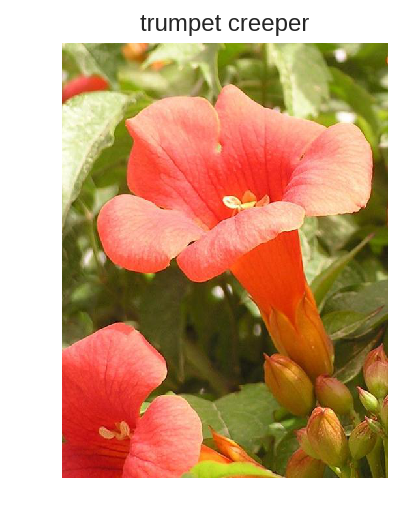

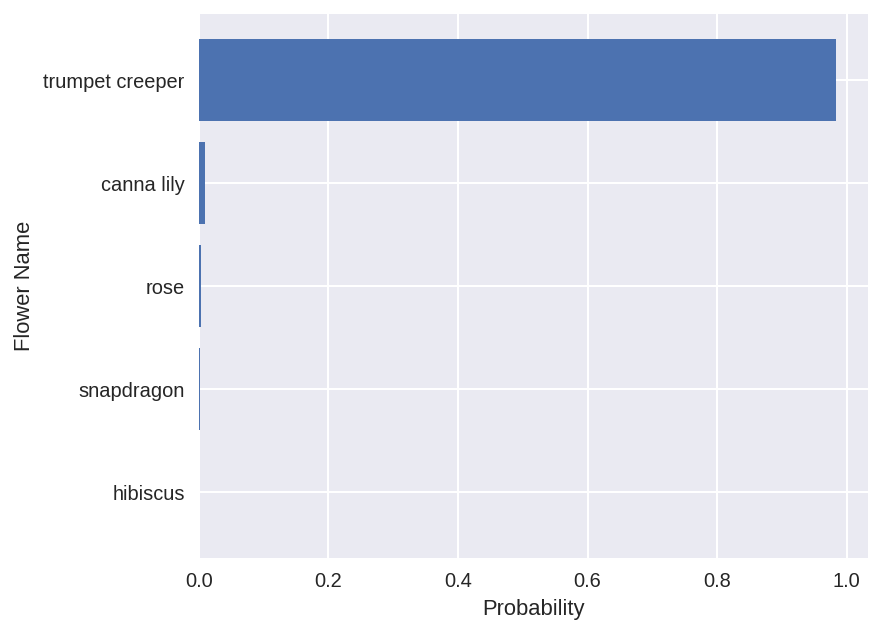

In [87]:
path = 'flowers/valid/101/image_07962.jpg'
sanity_check(path)

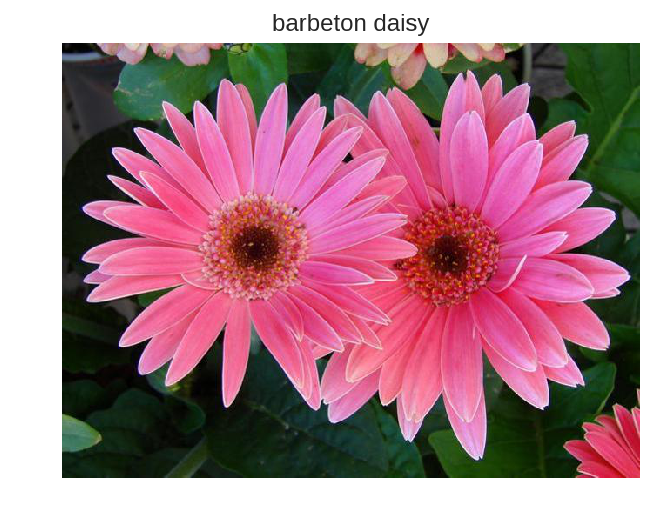

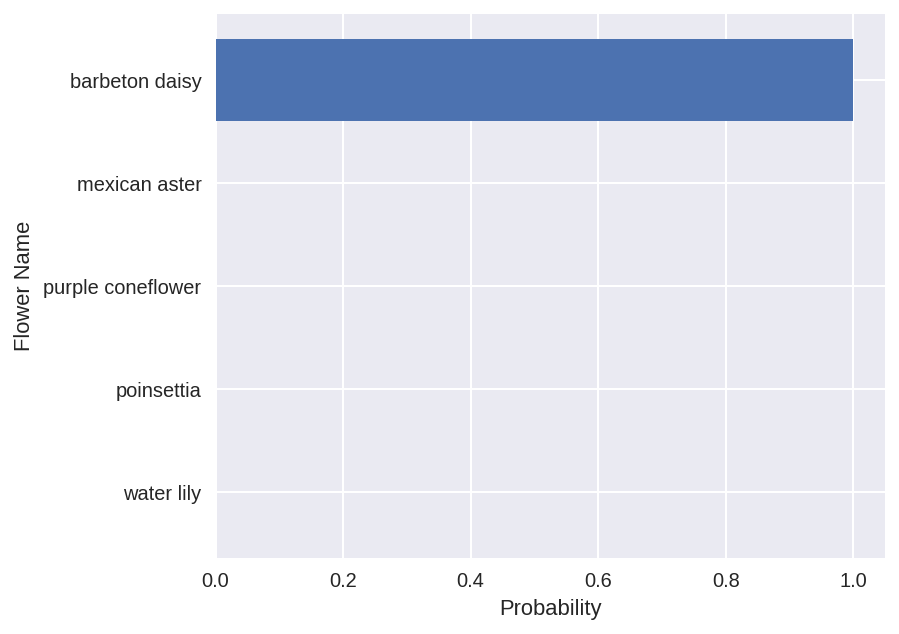

In [88]:
path = 'flowers/test/41/image_02257.jpg'
sanity_check(path)

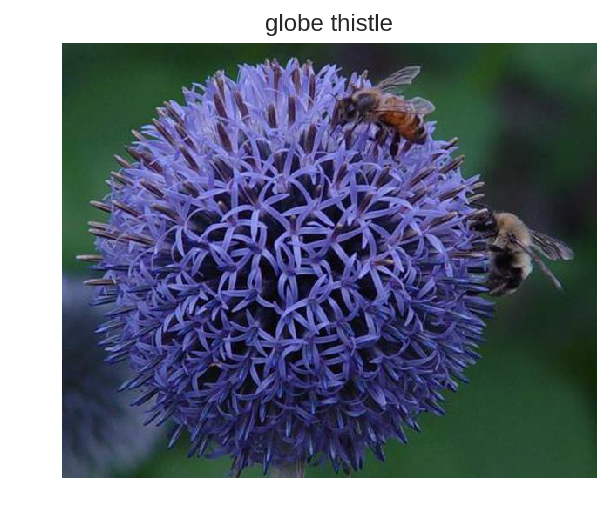

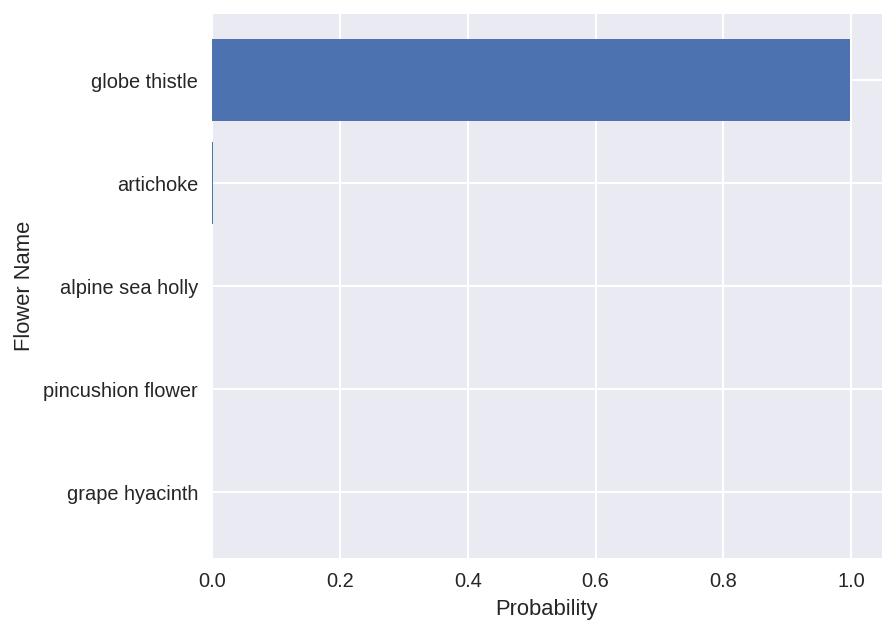

In [89]:
path = 'flowers/test/10/image_07090.jpg'
sanity_check(path)